# Experiment on the Math PhD Exchange

This data set comes from the article ["Eigenvector-Based Centrality Measures for Temporal Networks
"](https://arxiv.org/abs/1507.01266) by Taylor, Myers, Clauset, Porter, and Mucha. What is tracked here is **not** hiring data. In each year, the authors scraped the number of PhDs produced at institution $j$ whose advisor received a PhD at institution $i$. This is arguably a proxy for hiring data, but there are several issues. For example, if a scholar is hired at institution $j$, they won't actually appear in this data set until their first PhD student graduates, which would presumably be 4-7 years after their hiring. 

Since our model is obviously mis-specified on this data, we should proceed with caution. 

In [1]:
import numpy as np
from SpringRank import SpringRank
# from itertools import chain
import matplotlib.pyplot as plt
from py import estimation, prep_data
import pandas as pd
%matplotlib inline

In [2]:
data_dir = 'data/PhD Exchange Network Data/'

top_n = 70
t_start = 13

T, labels, timesteps = prep_data.prep_math_phd(data_dir, top_n = top_n)
T, timesteps, A0, n_obs = prep_data.initial_condition(T, timesteps, t_start)

In [3]:
# search space

lam_grid = 101 # resolution in $\lambda$
b_grid = 101   # resolution in $\beta$

LAMBDA = np.linspace(.5, 1, lam_grid) # lambda values at which to evaluate
BETA = np.linspace(0, 5, b_grid)            # beta values at which to evaluate

In [4]:
# compute the likelihood at each combination of lambda and beta. 
# might take a little while depending on lam_grid, beta_grid, n, and n_rounds

M = estimation.likelihood_surface(T, 
                                  LAMBDA, 
                                  BETA, 
                                  A0, 
                                  fun = SpringRank.SpringRank, 
                                  alpha = .0001) 

M_deg = estimation.likelihood_surface(T, 
                                      LAMBDA, 
                                      BETA, 
                                      A0, 
                                      fun = lambda A: A.sum(axis = 1))

M_uniform = estimation.likelihood_surface(T, 
                                      LAMBDA, 
                                      BETA, 
                                      A0, 
                                      fun = lambda A: np.ones(A.shape[0]))

In [5]:
for mat in [M, M_deg, M_uniform]:
    print(round(mat.max()/n_obs.sum(), 2), estimation.get_estimates(mat, BETA, LAMBDA))

-5.08 {'beta': 2.25, 'lambda': 0.845, 's_beta': 0.002979877881405671, 's_lambda': 0.06764425470891015}
-5.05 {'beta': 0.2, 'lambda': 0.86, 's_beta': 0.00024722605532822553, 's_lambda': 0.09196437716307437}
-5.61 {'beta': 1.4500000000000002, 'lambda': 0.5, 's_beta': nan, 's_lambda': nan}


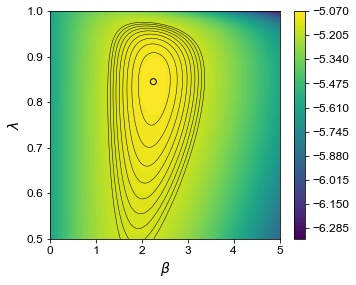

In [10]:
fig = plt.figure(figsize = (5,4))
ax = fig.add_subplot(111)

xg, yg = np.meshgrid(BETA, LAMBDA)

im = ax.contourf(xg, yg, M/n_obs, levels = 100)
ax.contour(xg, yg, M/n_obs, 
           levels = np.linspace(M.max()/n_obs - .1, 
                                M.max()/n_obs, 10), 
           linewidths = .5, 
           colors = 'black', 
           linestyles = 'solid')

plt.colorbar(im)

ax.set(xlabel = r'$\beta$',
       ylabel = r'$\lambda$')

hat = estimation.get_estimates(M, BETA, LAMBDA)
beta_hat = hat['beta']
lambda_hat = hat['lambda']

ax.scatter(beta_hat, lambda_hat, color = 'black', facecolor = 'None')

plt.tight_layout()

# Time-Series Visualization

Now that we have plausible(??) values for $\lambda$ and $\beta$, we can visualize time-series of $\gamma$.

In [11]:
hat = estimation.get_estimates(M, BETA, LAMBDA)

tau = timesteps[t_start:]

# t = T_.shape[0]
# lam = lambda_hat
n_rounds = T.shape[0]
# beta = beta_hat

# def plot_gammas(T, lam, title = '', figsize = (5,4)):
A = estimation.state_matrix(T, hat['lambda'], A0) # check in on this state matrix computation, seems off
GAMMA = np.zeros((n_rounds, top_n))
for k in range(n_rounds):
    GAMMA[k] = estimation.compute_gamma(A[k], hat['beta'])
    
top_trajectories = np.unique(GAMMA.argmax(axis = 1))
top_trajectories = (-GAMMA.mean(axis = 0)).argsort()[0:6]

# A prettier version

The code below just takes these two plots and combines them into a single figure, with some cosmetics. 

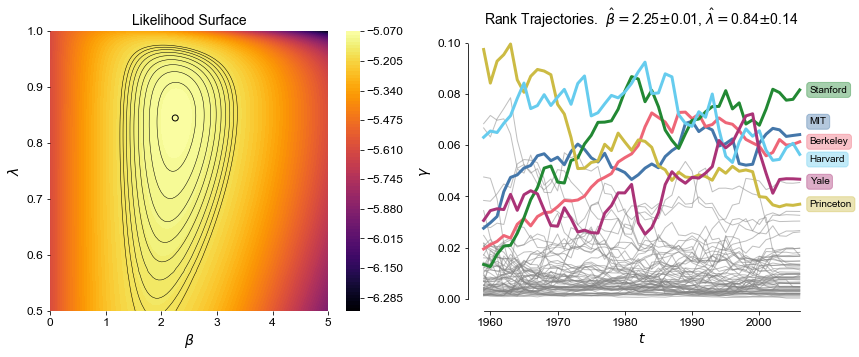

In [15]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial Unicode MS"

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig = plt.figure(figsize = (12,5))

ax1 = fig.add_subplot(121)
xg, yg = np.meshgrid(BETA, LAMBDA)

im = ax1.contourf(xg, yg, M / n_obs, levels = 100, cmap = 'inferno')
ax1.contour(xg, yg, M/n_obs, 
           levels = np.linspace(M.max()/n_obs-.1, 
                                M.max()/n_obs, 10), 
           linewidths = .5, 
           colors = 'black', 
           linestyles = 'solid')

cb = plt.colorbar(im)
cb.outline.set_visible(False)

#     ax.scatter(beta, lam, color = 'black')

ax1.set(xlabel = r'$\beta$',
       ylabel = r'$\lambda$',
       title = 'Likelihood Surface')


ax1.scatter(hat['beta'], hat['lambda'], color = 'black', facecolor = 'None')

for pos in ['top', 'right', 'left', 'bottom']: 
    ax1.spines[pos].set_visible(False)

ax2 = fig.add_subplot(122)

shortener = {
    'Massachusetts Institute of Technology' : 'MIT',
    'University of California, Berkeley' : 'Berkeley', 
    'Stanford University' : 'Stanford',
    'Princeton University' : 'Princeton',
    'Harvard University' : 'Harvard',
    'Yale University' : 'Yale',
    'The University of Chicago' : 'Chicago'
}

cset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']

label_adjustments = {
    'MIT': 0.005,
    'Berkeley' : 0,
    'Harvard': -0.002,
    'Stanford' : 0,
    'Chicago' : 0,
    'Princeton' : 0, 
    'Yale' : -0.001
}

k = 0

for l in range(top_n):
    if l not in top_trajectories:
        ax2.plot(tau, GAMMA[:,l], color = 'grey', alpha = .5, linewidth = 1)

for l in range(top_n):
    if l in top_trajectories: 
        name = shortener[labels[l]]
        ax2.plot(tau, GAMMA[:,l], alpha = 1, linewidth = 3, 
                 label = name, color = cset[k])
        
        ax2.annotate(shortener[labels[l]],
                  xy=(tau.max(), GAMMA[-1:,l] + label_adjustments[name]), xycoords='data',
                  xytext=(10, 0), textcoords='offset points',
                  size=10, va="center", color = 'black',
                  bbox=dict(boxstyle="round",  color = cset[k], alpha = .4)
#                   arrowprops=dict(arrowstyle="wedge,tail_width=1.",
#                                   fc=(1.0, 0.7, 0.7), ec="none",
#                                   patchA=None,
#                                   patchB=el,
#                                   relpos=(0.2, 0.5)))
                    )
        
        
        k += 1
        
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_bounds(0, GAMMA.max())
ax2.spines['bottom'].set_bounds(tau.min(), tau.max())

ax2.set(xlabel = r'$t$',
       ylabel = r'$\gamma$', 
       title = r'Rank Trajectories.  $\hat{\beta} = $' + str(round(hat['beta'], 2)) + r'$\pm$' + str(round(2*hat['s_beta'], 2)) + r', $\hat{\lambda} = $' + str(round(hat['lambda'], 2)) + r'$\pm$' + str(round(2*hat['s_lambda'], 2)))

# ax2.legend(loc='upper center', bbox_to_anchor=(1.1, 0.7),
#           fancybox=False, shadow=False, ncol=1, frameon = False)

# fig.suptitle('Math PhD Exchange', fontsize = 16)

plt.tight_layout()

plt.savefig('fig/math_phd_exchange.png', dpi = 300, bbox_inches = 'tight')